In [1]:
import sys
sys.path.append('../../')

In [2]:
from definitions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from notebooks.nb_imports import *
import scipy.stats as stats
from sklearn.metrics import mean_squared_error as mse

In [3]:
# Raw dataframe
df = load_pickle(ROOT_DIR + '/data/interim/munged/df.pickle')
labels_utility_raw = load_pickle(ROOT_DIR + '/data/processed/labels/utility_scores.pickle')
labels_binary_raw = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')

/Users/jambo/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [4]:
df = load_pickle(ROOT_DIR + '/data/interim/from_raw/df.pickle')

In [5]:
df.head()

HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  \
id time                                                                         
1  0       NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN   
   1      97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN   
   2      89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN   
   3      90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN   
   4     103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN   

         ...  WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  \
id time  ...                                                            
1  0     ...  NaN         NaN        NaN  83.14       0    NaN    NaN   
   1     ...  NaN         NaN        NaN  83.14       0    NaN    NaN   
   2     ...  NaN         NaN        NaN  83.14       0    NaN    NaN   
   3     ...  NaN         NaN        NaN  83.14       0    NaN    NaN   
   4     ...  NaN         NaN        NaN  83.14       0    NaN    NaN   

         HospAdmTime  ICULOS  hospital  
id time                                 
1  0           -0.03       1         1  
   1           -0.03       2         1  
   2           -0.03       3         1  
   3           -0.03       4         1  
   4           -0.03       5         1  

[5 rows x 41 columns]

# Understanding the distn

In [6]:
# We only care about the people who eventually develop sepsis
sepsis_ids = labels_binary_raw[labels_binary_raw > 0].index.get_level_values('id').unique()
labels_utility = labels_utility_raw.loc[sepsis_ids]
labels_binary = labels_binary_raw.loc[sepsis_ids]

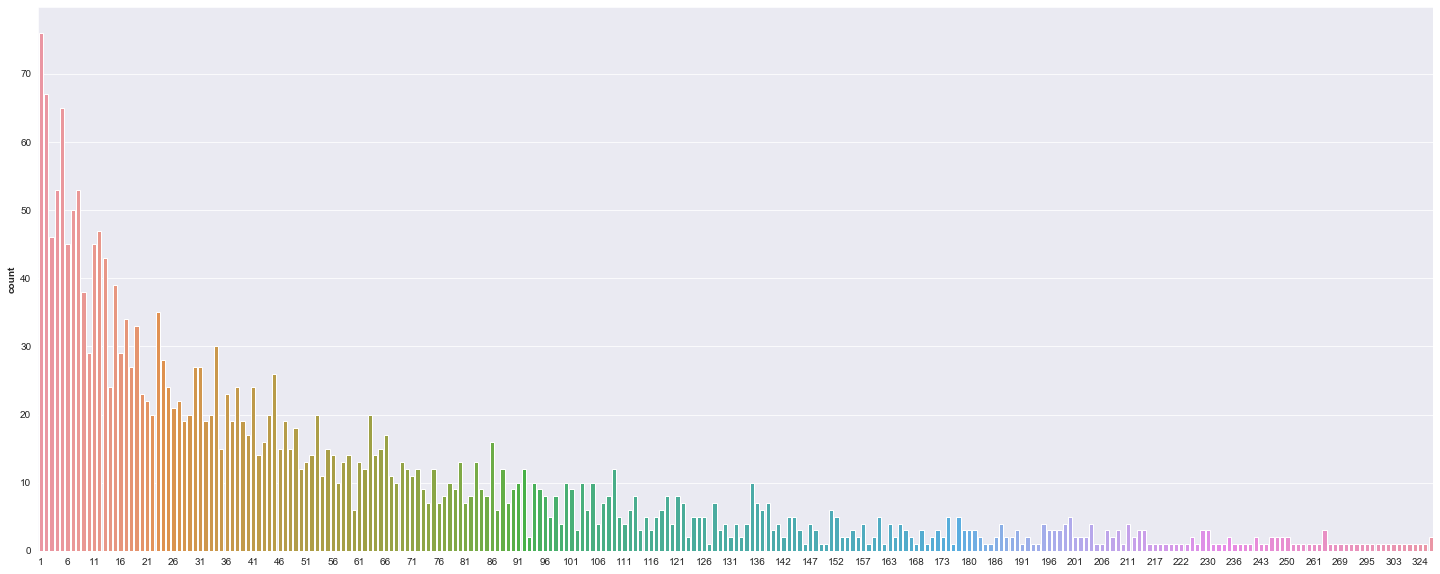

In [9]:
# Get the first time locations
first_times = labels_utility[labels_utility == 1].index.get_level_values('time')

# Plot first_time distn
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.countplot([x for x in first_times if x != 0], ax=ax)
remove_plot_ticks(ax, n=5)

In [10]:
# Plot first time as a ratio of those remaining
s = pd.Series(index=labels_binary.loc[sepsis_ids].index, data=0)
s.loc[labels_utility[labels_utility == 0].index] = 1

(0, 0.1)

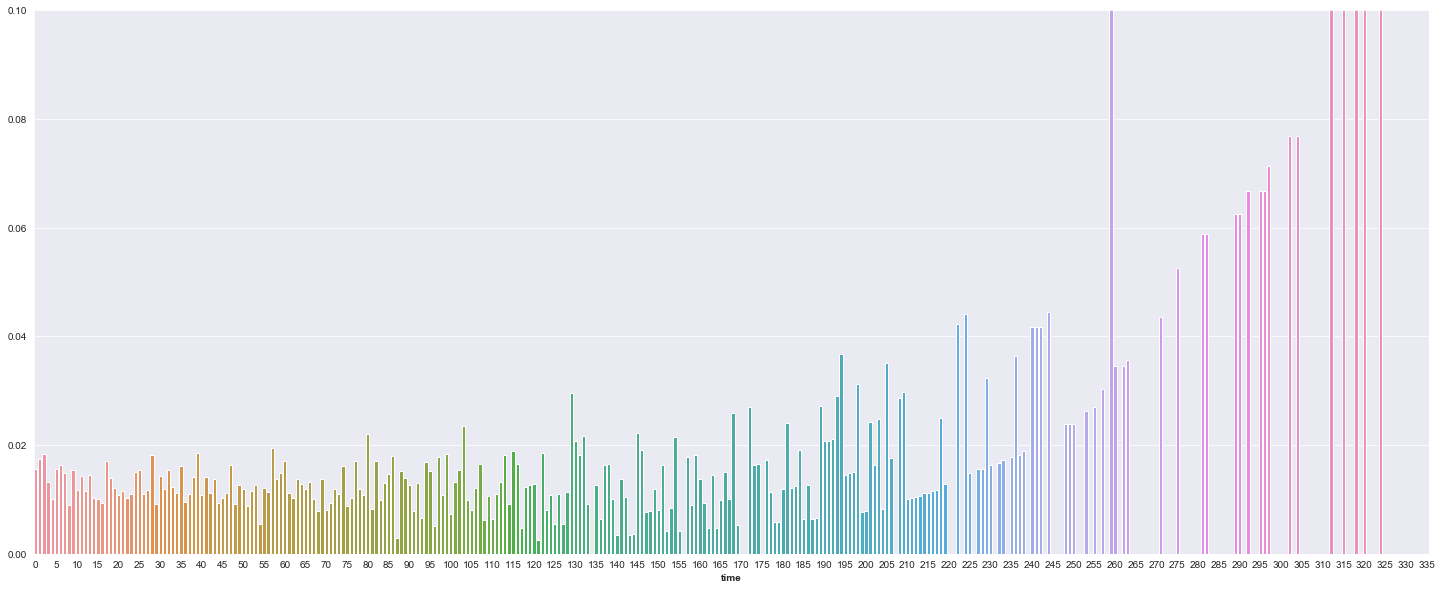

In [11]:
ax = plot_label_zero_to_one_ratio(s);
ax.set_ylim([0, 0.1])

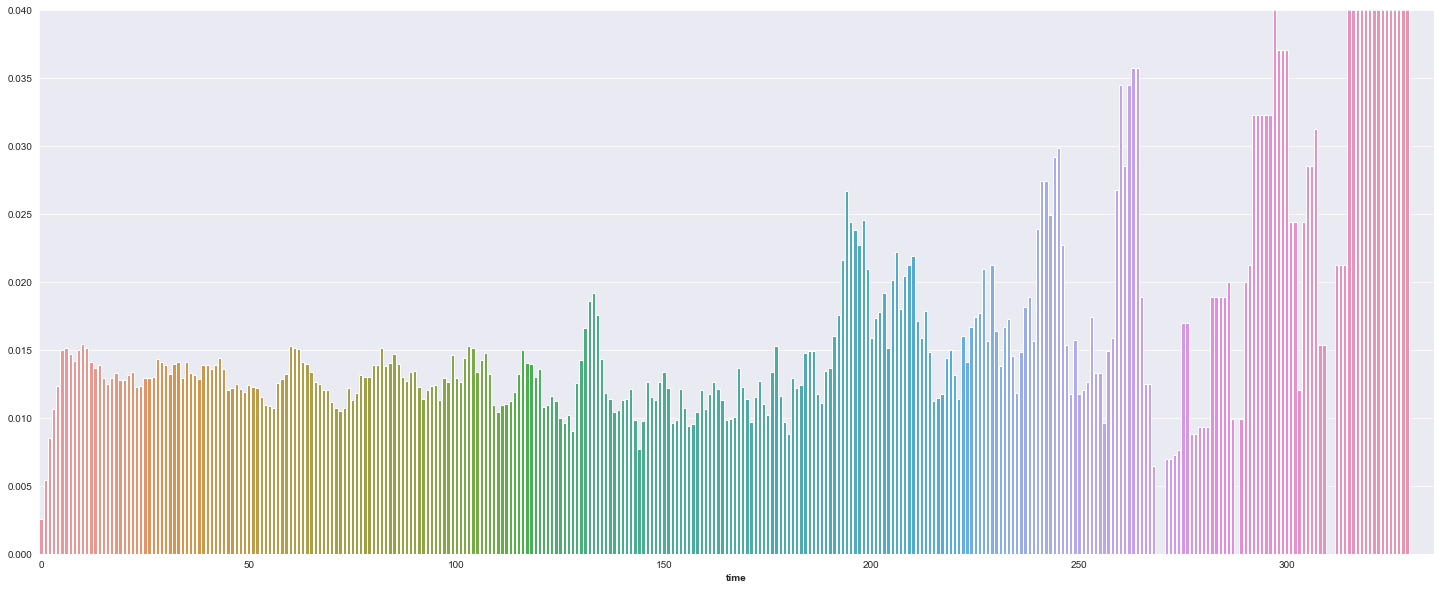

In [33]:
# With a 6 hour rolling mean window
ax = plot_label_zero_to_one_ratio(s.rolling(6).mean());
ax.set_ylim([0, 0.04])
# Remove ticks
remove_plot_ticks(ax, 10)
plt.savefig('./figures/stationary_sepsis.png', dpi=300, bbox_inches='tight')

# Evaluating if constant rate of infection

## Number with sepsis over time

Here we plot the number of those that eventually develop sepsis that are do not yet have sepsis over time.

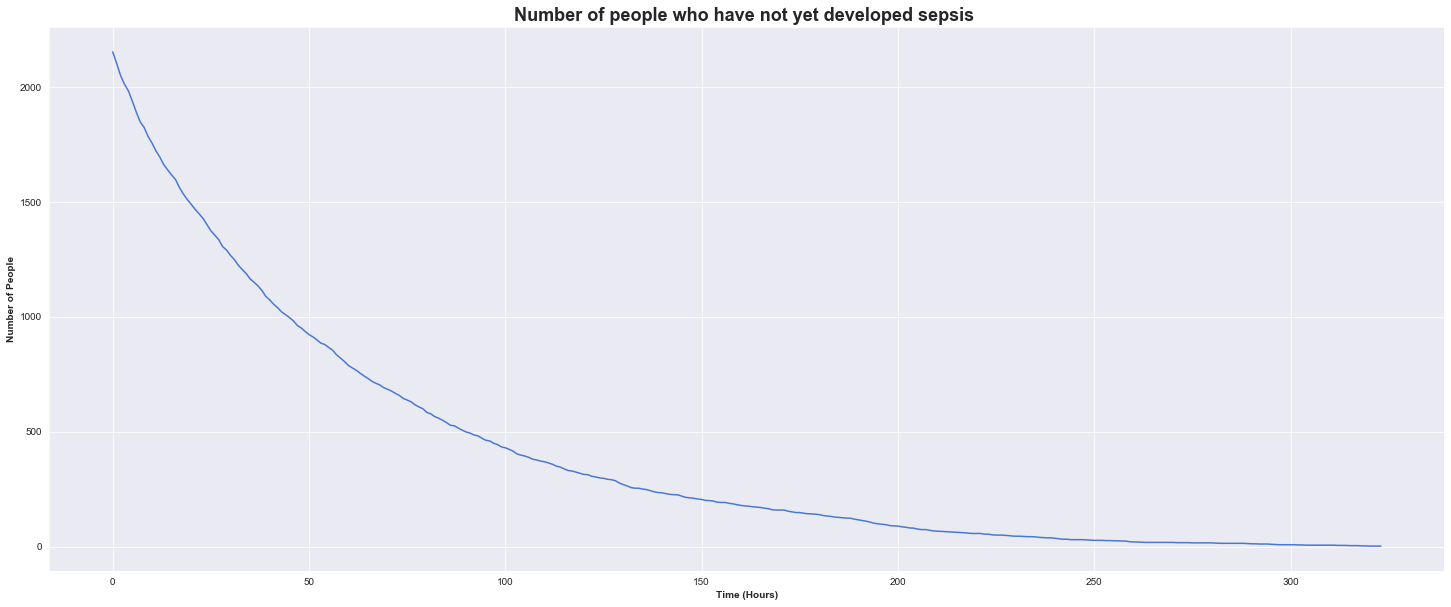

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

num_without_sepsis = labels_utility[labels_utility == -0.05].groupby('time').sum() * - 20
plt.plot(num_without_sepsis)
plt.title('Number of people who have not yet developed sepsis ', fontweight='bold', fontsize=18)
plt.xlabel('Time (Hours)')
plt.ylabel('Number of People')

plt.savefig('./figures/num_with_sepsis.png')

### Exponential fit

In [14]:
import scipy.optimize as optimization

# Optimize the exponential e^(-lambda*x)
def func(xdata, lmbda1, lmbda2):
    return lmbda2* np.exp(-lmbda1 * xdata)

# Time and num people without sepsis
xdata, ydata = np.array(num_without_sepsis.index.get_level_values('time')), num_without_sepsis.values

# Perform optimization
opt = optimization.curve_fit(func, xdata, ydata)
params = opt[0]

/Users/jambo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [15]:
print('Paramter lambda found to be {:.3f}'.format(params[0]))
print('This means you have a {:.3f}% chance of developing sepsis at any given hour'.format(lmbda[0] * 100))

Paramter lambda found to be 0.016


NameError: name 'lmbda' is not defined

## Closeness of cdf

### Exponential

# Evaluating the different hospitals
My thought here is if there is a better fit for each hospital then the theory holds even better.

In [16]:
labels_1, labels_2 = labels_utility[df['hospital'] == 1], labels_utility[df['hospital'] == 2]

## Hospital 1

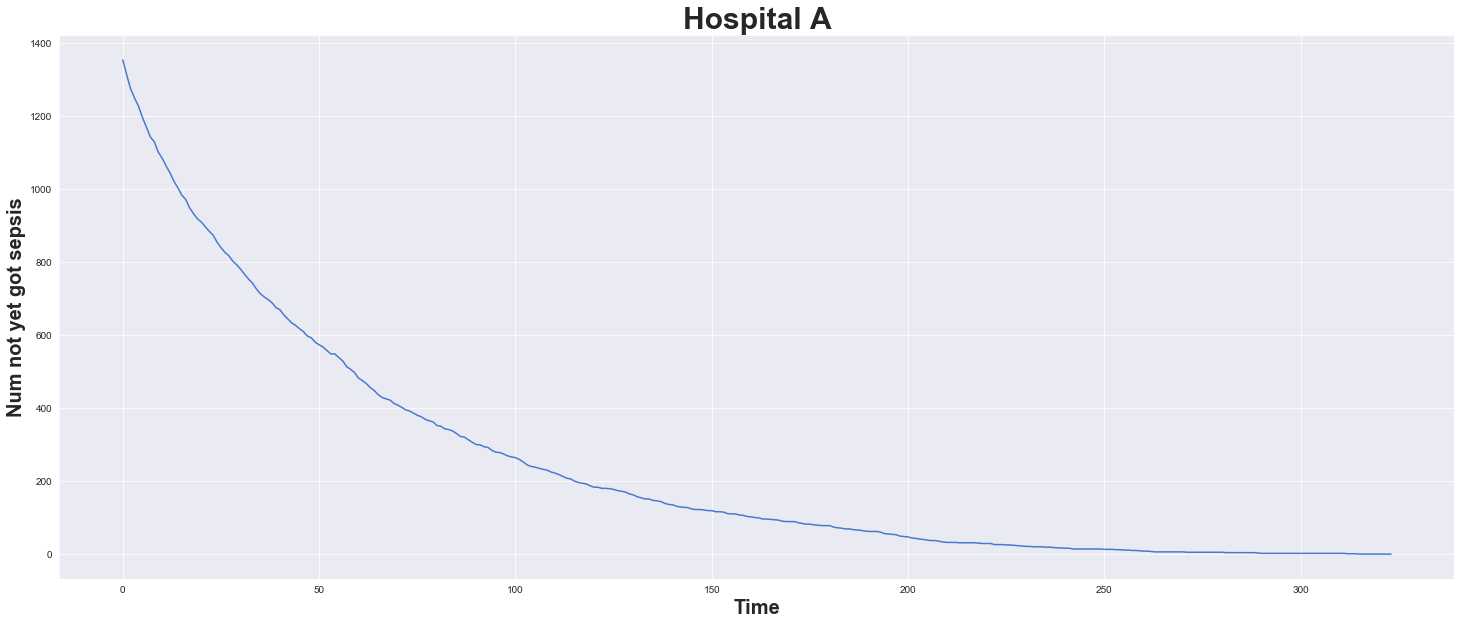

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

num_without_sepsis_1 = labels_1[labels_1 == -0.05].groupby('time').sum() * - 20
plt.plot(num_without_sepsis_1)

# Axis options
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num not yet got sepsis', fontsize=20)
ax.set_title('Hospital A', fontsize=30, fontweight='bold')

plt.savefig('./figures/stationary/hospital_A_rate.png', dpi=300, bbox_inches='tight')

In [18]:
import scipy.optimize as optimization

# Optimize the exponential e^(-lambda*x)
def func(xdata, lmbda1, lmbda2):
    return lmbda2 * np.exp(-lmbda1 * xdata)

# Time and num people without sepsis
xdata_1, ydata_1 = np.array(num_without_sepsis_1.index.get_level_values('time')), num_without_sepsis_1.values


# Perform optimization
params_1, _ = optimization.curve_fit(func, xdata_1, ydata_1)

/Users/jambo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [22]:
print('Paramter lambda found to be {:.3f}'.format(params_1[0]))
print('This means you have a {:.3f}% chance of developing sepsis at any given hour'.format(params_1[0] * 100))

Paramter lambda found to be 0.016
This means you have a 1.619% chance of developing sepsis at any given hour


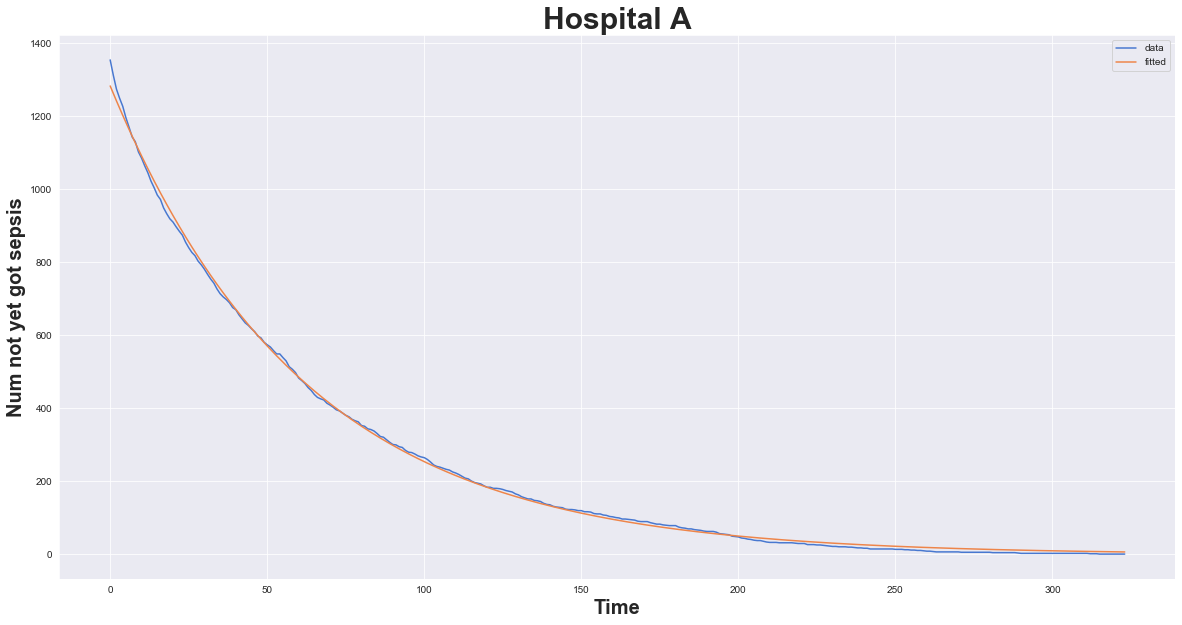

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot actual data
ax.plot(xdata_1, ydata_1, label='data')

# Plot fitted curve
ax.plot(xdata_1, func(xdata_1, params_1[0], params_1[1]), label='fitted')

# Axis options
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num not yet got sepsis', fontsize=20)
ax.set_title('Hospital A', fontsize=30, fontweight='bold')
ax.legend()

# Save
plt.savefig('./figures/stationary/hospital_A_rate_with_exp.png', dpi=300, bbox_inches='tight')

## Hospital 2

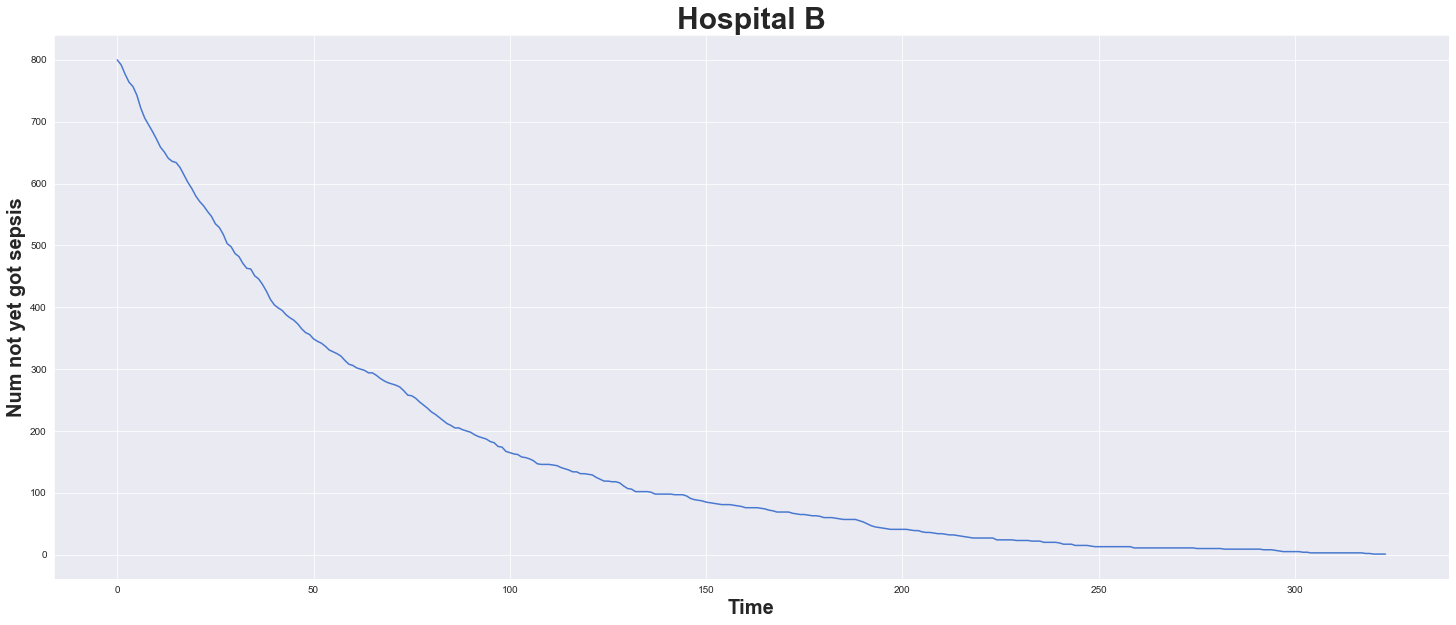

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

num_without_sepsis_2 = labels_2[labels_2 == -0.05].groupby('time').sum() * - 20
plt.plot(num_without_sepsis_2)

# Axis options
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num not yet got sepsis', fontsize=20)
ax.set_title('Hospital B', fontsize=30, fontweight='bold')

plt.savefig('./figures/stationary/hospital_B_rate.png', dpi=300, bbox_inches='tight')

In [25]:
import scipy.optimize as optimization

# Optimize the exponential e^(-lambda*x)
def func(xdata, lmbda1, lmbda2):
    return lmbda2 * np.exp(-lmbda1 * xdata)

# Time and num people without sepsis
xdata_2, ydata_2 = np.array(num_without_sepsis_2.index.get_level_values('time')), num_without_sepsis_2.values

# Perform optimization
params_2, _ = optimization.curve_fit(func, xdata_2, ydata_2)

/Users/jambo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [26]:
print('Paramter lambda found to be {:.3f}'.format(params_2[0]))
print('This means you have a {:.3f}% chance of developing sepsis at any given hour'.format(params_2[0] * 100))

Paramter lambda found to be 0.015
This means you have a 1.530% chance of developing sepsis at any given hour


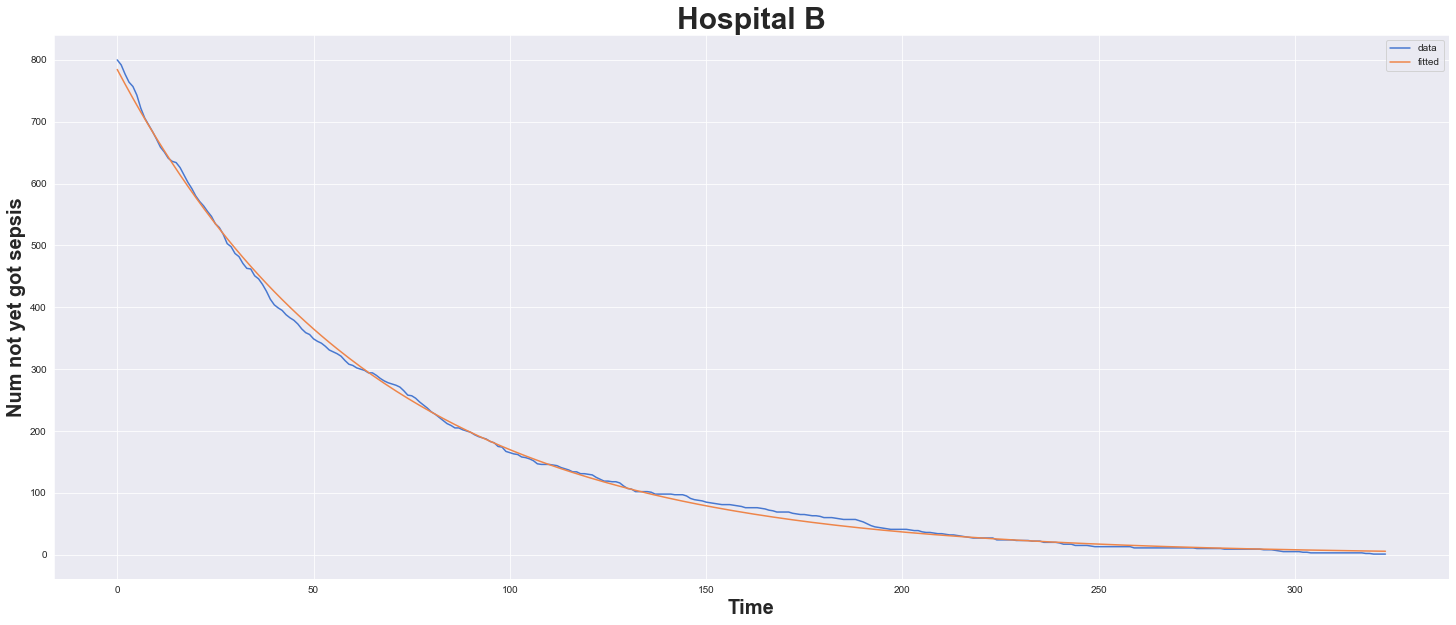

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

# Plot actual data
ax.plot(xdata_2, ydata_2, label='data')

# Plot fitted curve
ax.plot(xdata_2, func(xdata_2, params_2[0], params_2[1]), label='fitted')

# Axis options
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num not yet got sepsis', fontsize=20)
ax.set_title('Hospital B', fontsize=30, fontweight='bold')
ax.legend()

plt.savefig('./figures/stationary/hospital_B_rate_with_exp.png', dpi=300, bbox_inches='tight')

## Both Hospital Graphs

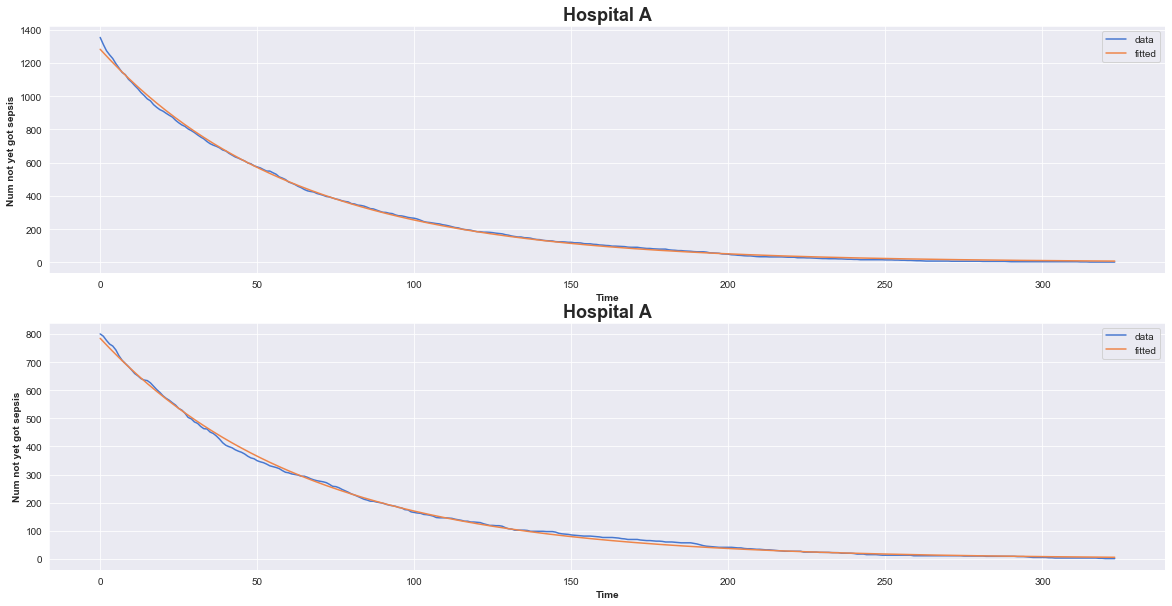

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Plot actual data
ax[0].plot(xdata_1, ydata_1, label='data')
ax[1].plot(xdata_2, ydata_2, label='data')

# Plot fitted curve
ax[0].plot(xdata_1, func(xdata_1, params_1[0], params_1[1]), label='fitted')
ax[1].plot(xdata_2, func(xdata_2, params_2[0], params_2[1]), label='fitted')

# Axis options
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Num not yet got sepsis')
ax[0].set_title('Hospital A', fontsize=18, fontweight='bold')
ax[0].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Num not yet got sepsis')
ax[1].set_title('Hospital A', fontsize=18, fontweight='bold')
ax[1].legend()

# Save
plt.savefig('./figures/stationary/hospitals_with_exp.png', dpi=300, bbox_inches='tight')

# Plotting decomission rate

In [42]:
labels = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')
labels_final_time = labels.reset_index('time').groupby('id').apply(lambda x: x.iloc[-1])
labels_final_ok = labels_final_time[labels_final_time['SepsisLabel'] == 0]
final_ok_times = labels_final_ok['time'].values

/Users/jambo/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


**Note that this is very much not exponential, which suggests that an exponential decay of patients is not the usual process**

No handles with labels found to put in legend.


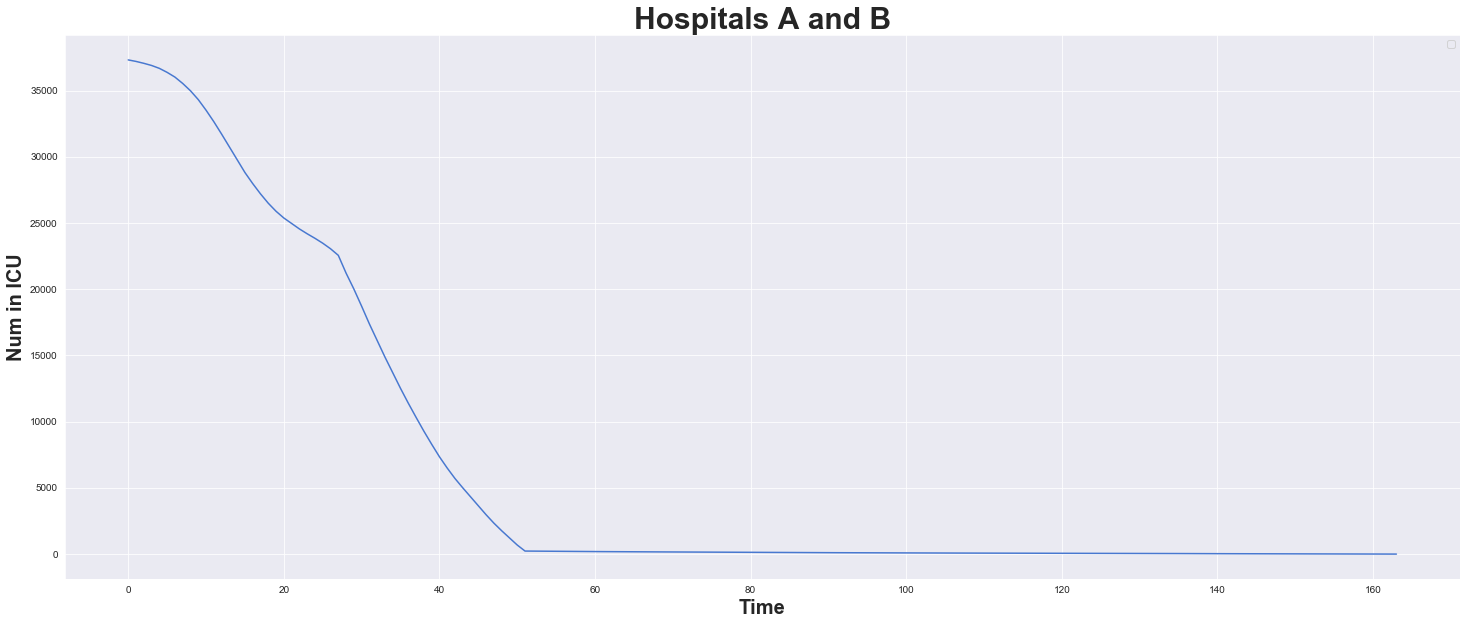

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
unique, count = np.unique(labels_final_ok['time'].values, return_counts=True)
ax.plot(labels_final_ok.shape[0] - count.cumsum())

# Axis options
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num in ICU', fontsize=20)
ax.set_title('Hospitals A and B', fontsize=30, fontweight='bold')
ax.legend()

plt.savefig('./figures/decomission_rate.png', dpi=300, bbox_inches='tight')